Links to other notebooks in the same folder:
<a href='http://pivotal.io/data-science'><img src='https://raw.githubusercontent.com/crawles/Logos/master/Pivotal_TealOnWhite.png' width='200px' align='right'></a>

<nav class = "navbar navbar-light bg-faded">
    <ul class = "nav navbar-nav">
        <li class = "">
            <a class = "nav-link">notebook1</a>
        </li>
        <li class = "">
            <a class = "nav-link">notebook2</a>
        </li>
        <li class = "">
            <a class = "nav-link">notebook3</a>
        </li>
        

# Load Libraries and Set Default Settings

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from IPython.core.display import display, HTML
import os
import sys
import urllib

from IPython.core.magic import register_line_magic, register_cell_magic, register_line_cell_magic
from IPython.display import display
from IPython.display import HTML
%matplotlib inline
# If we want to move the graph
# %matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import seaborn as sns

# Credentials file to connect to database
import credentials
from sql_functions import *
from mpp_plotting_functions import *

/Users/gregorytam/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Changes logo to a Pivotal logo
jPrefs = urllib.urlopen("https://raw.githubusercontent.com/crawles/Logos/master/jupyterPrefs.js").read()
HTML('<script>{}</script>'.format(jPrefs))

In [3]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
mpl.rcParams['figure.figsize'] = (10, 7)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['figure.titlesize'] = 26
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

# Set Seaborn Colours
blue, green, red, purple, yellow, cyan = sns.color_palette()

# Connect to Database

In [4]:
conn = psycopg2.connect(database=credentials.database,
                        user=credentials.user,
                        password=credentials.password,
                        host=credentials.host
                       )
conn.autocommit = True

# Define magic functions - helpful for interacting with cluster

In [5]:
@register_cell_magic
def readsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL), 
    and execute it using the connection object to the backend 
    database. The resulting pandas DataFrame is rendered inline 
    below the cell using IPython.display. You'd use this for SELECT.
    
    Returns a DataFrame with the name specified in the magic
    function. If this is not specified, then the DataFrame
    is called _df.
    """
    # Use the global connection object defined above.
    global conn
    table_name = line
    # If there is more than one table name specified,
    # throw an exception.
    if len(table_name.split()) > 1:
        raise Exception('More than one table name specified')

    if len(table_name.split()) > 0:
        # If a table name is specified, store it as that
        globals()[table_name] = psql.read_sql(cell.format(**globals()), conn)
        display(globals()[table_name])

    else:
        # Otherwise, call it _df
        global _df
        _df = psql.read_sql(cell.format(**globals()), conn)
        display(_df)

    
@register_cell_magic
def execsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL),
    and execute it using the connection object to the backend 
    database. You'd use this for CREATE/UPDATE/DELETE.
    """
    # Use the global connection object defined above.
    global conn
    psql.execute(cell.format(**globals()), conn)

# We delete these to avoid name conflicts for automagic to work
del execsql, readsql

# Defining our Functions

We can calculate our histogram and scatterplot bins via the formula: 
$$\text{bin_num}(x) = \frac{1}{n_{bins}} \left\lfloor \frac{x-\min(x)}{\max(x) - \min(x) + \varepsilon} * n_{bins} \right\rfloor  \times \left\{\max(x) - \min(x)\right\} + \min(x)$$
The variable $\varepsilon>0$ is a small number. This ensures that the fraction in the floor function is never equal to 1. This would happen in the case that $x$ is equal to the maximum and we would have a bin with potetially only one value (i.e., the max value).

In [ ]:
#TODO: Add feature so that table_name can take in schema name (e.g., schema.table)

# Creating Fake Data

Begin by creating random fake data. We will add some NULL rows too.

In [ ]:
%%execsql
DROP TABLE IF EXISTS test_data;
CREATE TABLE test_data
   AS SELECT random()^2 * 50 AS log_col,
             50 - random()^2 * 50 AS log_col_2,
             (random()^2 * 50)::INT AS log_col_int,
             CASE WHEN random() < 0.5 THEN 'category_a'
                  WHEN random() < 0.7 THEN 'category_b'
                  WHEN random() < 0.85 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_1,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.6 THEN 'category_c'
                  WHEN random() < 0.8 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.65 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_3,
             (random()*100 + 50)::text AS uncasted_col
        FROM generate_series(1, 10000)
       UNION ALL
      SELECT NULL AS log_col,
             50 - random()^2 * 50 AS log_col_2,
             (random()^2 * 50)::INT AS log_col_int,
             NULL AS category_1,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.6 THEN 'category_c'
                  WHEN random() < 0.8 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             NULL AS category_3,
             NULL AS uncasted_col
        FROM generate_series(1, 1000);
        

DROP TABLE IF EXISTS small_test_data;
CREATE TABLE small_test_data
   AS SELECT random()^2 * 50 AS log_col,
             50 - random()^2 * 50 AS log_col_2,
             (random()^2 * 50)::INT AS log_col_int,
             CASE WHEN random() < 0.5 THEN 'category_a'
                  WHEN random() < 0.7 THEN 'category_b'
                  WHEN random() < 0.85 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_1,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.6 THEN 'category_c'
                  WHEN random() < 0.8 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.65 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_3,
             (random()*100 + 50)::text AS uncasted_col
        FROM generate_series(1, 1000)
       UNION ALL
      SELECT NULL AS log_col,
             50 - random()^2 * 50 AS log_col_2,
             (random()^2 * 50)::INT AS log_col_int,
             NULL AS category_1,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.6 THEN 'category_c'
                  WHEN random() < 0.8 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             NULL AS category_3,
             NULL AS uncasted_col
        FROM generate_series(1, 100);

In [ ]:
%%readsql
SELECT *
  FROM test_data
 LIMIT 10;

# Plotting Categorical Histograms

In [86]:
category_hist_df = get_histogram_values('test_data', 'category_1', nbins=25)
category_hist_df_2 = get_histogram_values('test_data', 'category_2', nbins=25)

## Plotting a Single Variable

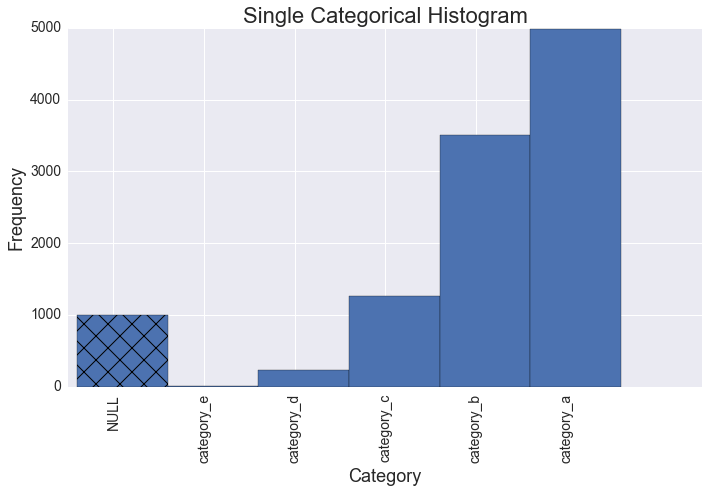

In [90]:
plot_categorical_hists([category_hist_df],
                        null_at='left',
                        order_by=0,
                        ascending=True,
                        log=False,
                        normed=False)
plt.title('Single Categorical Histogram'.format(null_at_list[i]))
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.tight_layout()

## Plotting Multiple Histograms

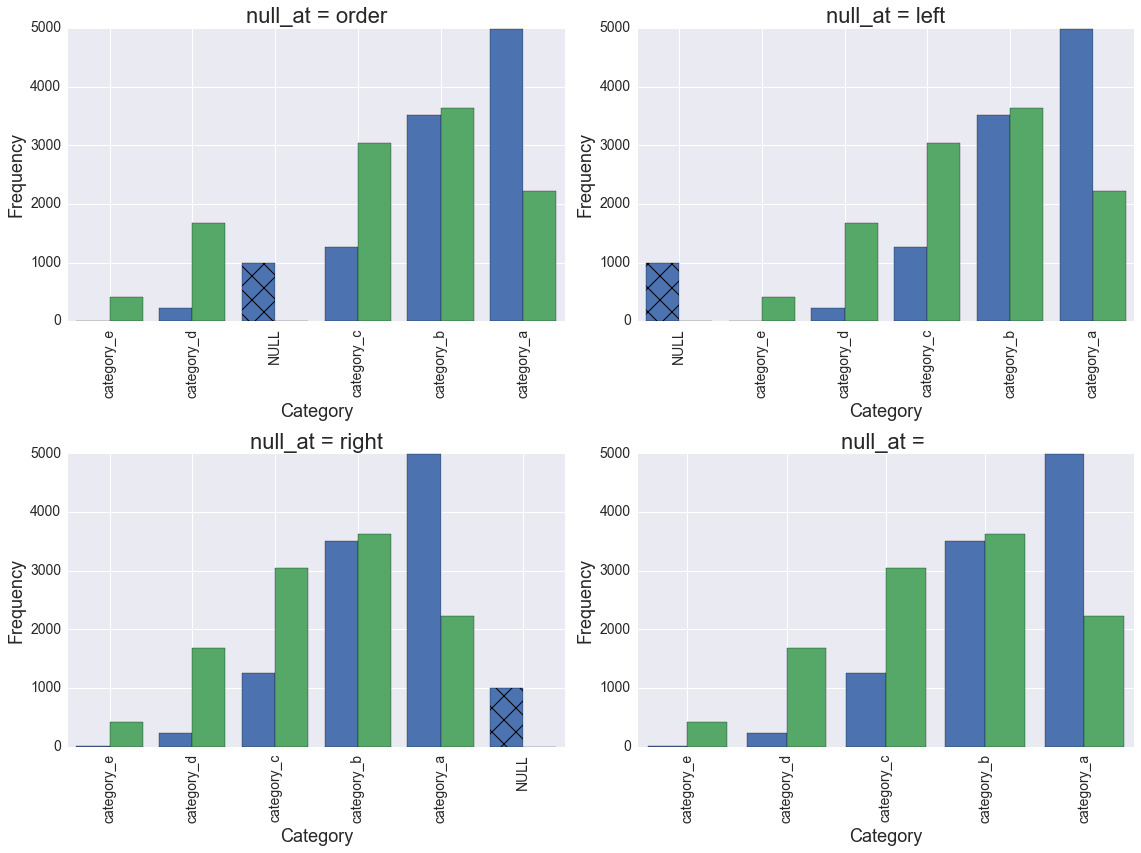

In [94]:
null_at_list = ['order', 'left', 'right', '']
plt.figure(figsize=(16, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plot_categorical_hists([category_hist_df, category_hist_df_2],
                           null_at=null_at_list[i],
                           order_by=0,
                           ascending=True
                          )
    plt.title('null_at = {}'.format(null_at_list[i]))
    plt.xlabel('Category')
    plt.ylabel('Frequency')

plt.tight_layout()

# Plot the Numerical Histograms

In [81]:
numeric_hist_df = get_histogram_values('test_data', 'log_col', nbins=25)
numeric_hist_df_2 = get_histogram_values('test_data', 'log_col_2', nbins=25)

## Plotting a Single Histogram

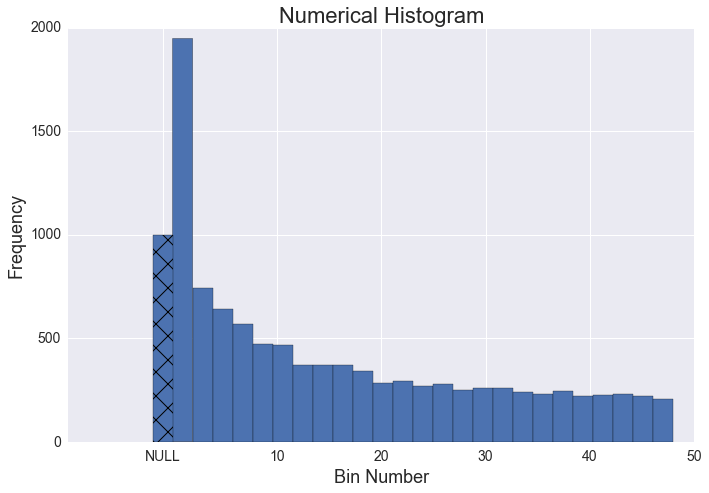

In [83]:
plot_numeric_hists([numeric_hist_df], nbins=25)
plt.title('Numerical Histogram')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

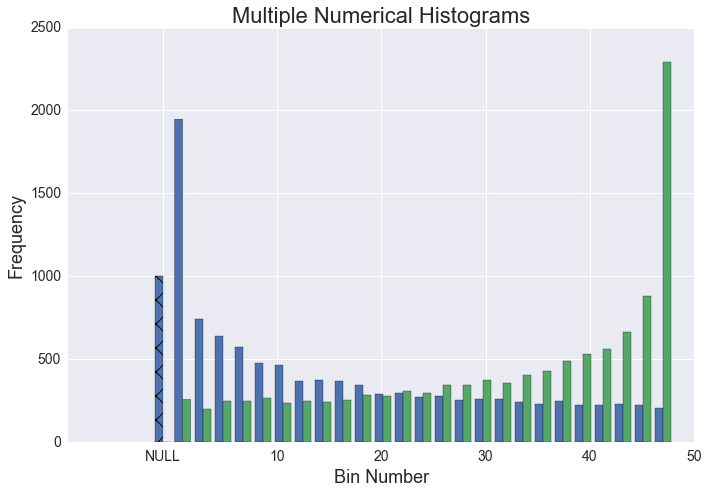

In [85]:
plot_numeric_hists([numeric_hist_df, numeric_hist_df_2], nbins=25)
plt.title('Multiple Numerical Histograms')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

## Recasting values
If a numeric field is misrepresented as text.

In [95]:
recasted_hist_df = get_histogram_values('test_data', 'uncasted_col', nbins=25, cast_as='float')

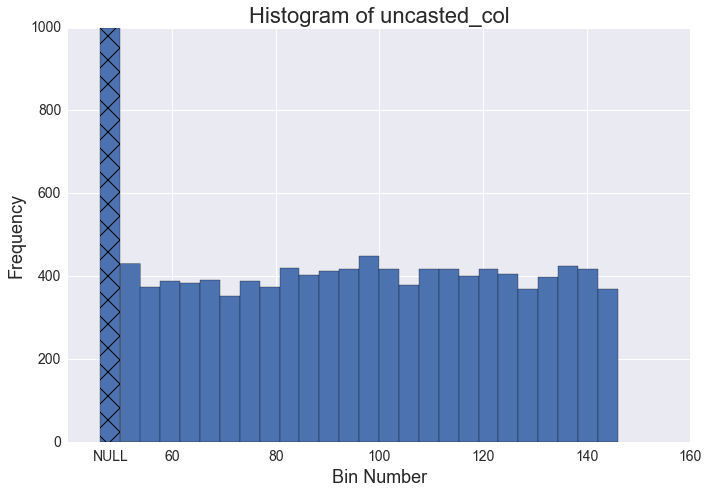

In [96]:
plot_numeric_hists(recasted_hist_df, nbins=25)
plt.title('Histogram of uncasted_col')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

## Plotting on a log scale

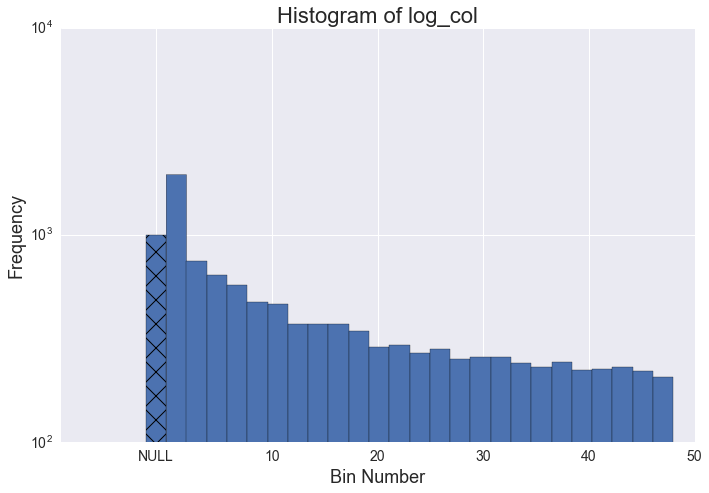

In [98]:
plot_numeric_hists(numeric_hist_df, nbins=25, log=True)
plt.title('Histogram of log_col')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

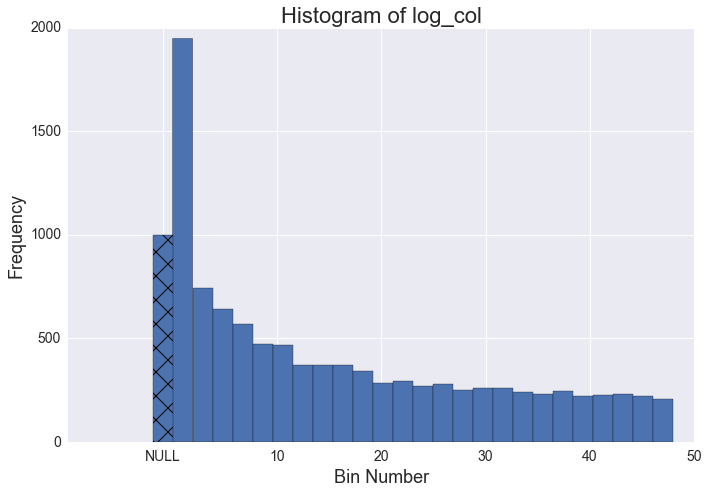

In [99]:
plot_numeric_hists(log_hist_df, nbins=25, log=False)
plt.title('Histogram of log_col')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

## Specifying Bin Width

In [121]:
log_int_hist_df = get_histogram_values('test_data', 'log_col_int', bin_width=1)

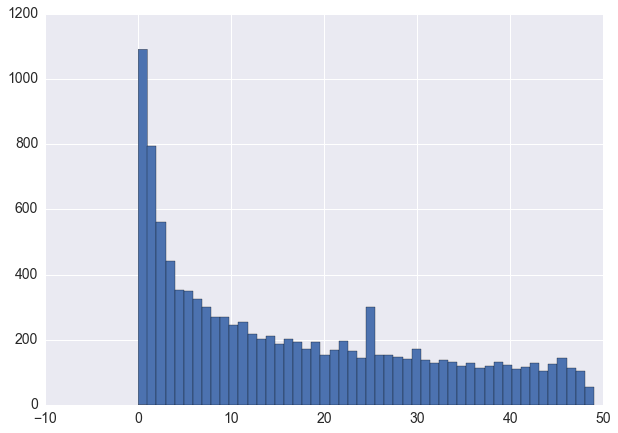

In [122]:
plot_numeric_hists(log_int_hist_df, nbins=log_int_hist_df.shape[0])

## Normalizing Plots
If we are plotting two or more histograms, they may be at different scales. For example, if we want to plot two histograms, but one has many more instances than the other, the smaller data set will not be visible on the histogram.

In [123]:
log_hist_df_small = get_histogram_values('small_test_data', 'log_col', nbins=25)

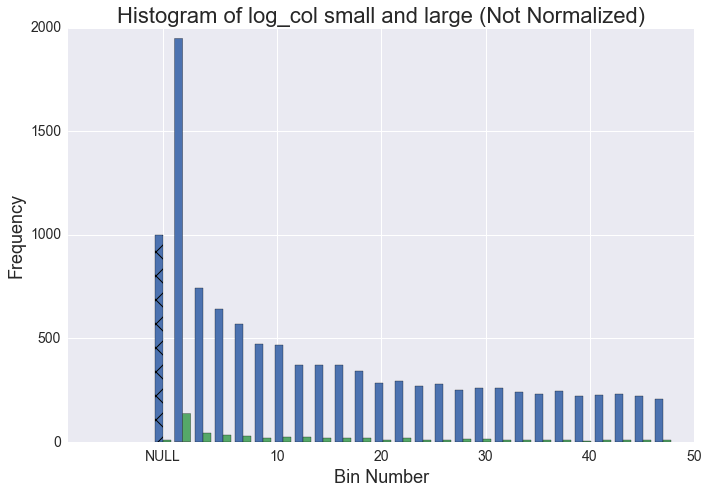

In [130]:
plot_numeric_hists([log_hist_df, log_hist_df_small], nbins=25, normed=False)
plt.title('Histogram of log_col small and large (Not Normalized)')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

The above plot illustrates the green, which is much smaller. There are a couple of things we can do. First, we can put everything onto the log scale.

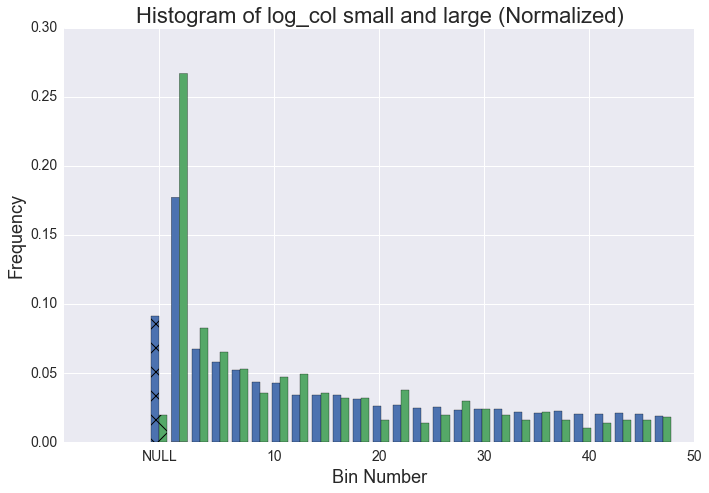

In [131]:
plot_numeric_hists([log_hist_df, log_hist_df_small], nbins=25, normed=True)
plt.title('Histogram of log_col small and large (Normalized)')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

# Plot the Summarized Data as a Scatter Plot

## Make Sizes Relative to Amount of Data

In [133]:
scatter_df = get_scatterplot_values('test_data', 'log_col', 'log_col_2', nbins=(50, 50))

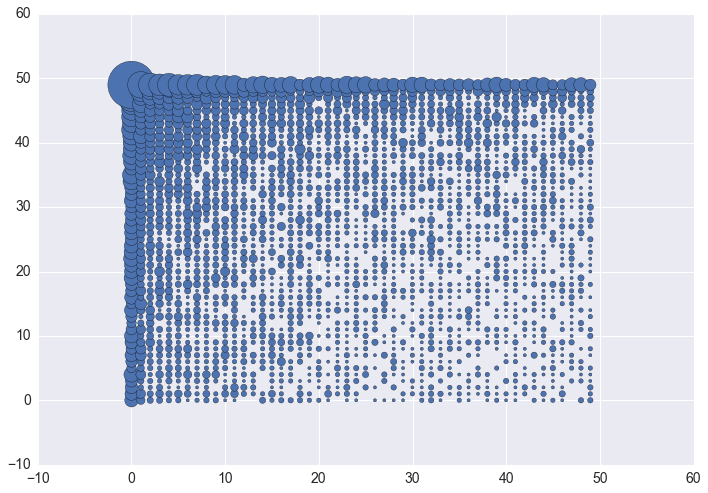

In [134]:
plt.scatter(scatter_df.bin_nbr_x, scatter_df.bin_nbr_y, c=blue, s=10*scatter_df.freq)
plt.tight_layout()

## Add Opacity

In [135]:
colour_matrix = np.zeros((scatter_df.dropna().shape[0], 4))
colour_matrix[:, :3] = blue
# Add alpha component
colour_matrix[:, 3] = scatter_df.dropna().freq/np.max(scatter_df.dropna().freq)

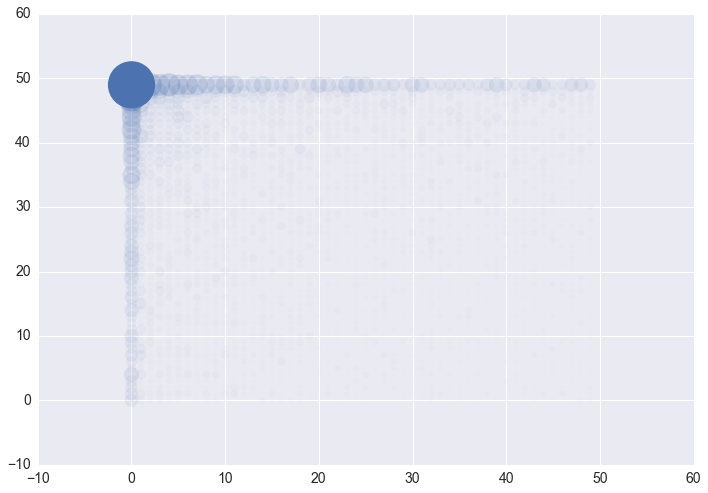

In [136]:
plt.scatter(scatter_df.bin_nbr_x, scatter_df.bin_nbr_y, c=colour_matrix, lw=0, s=10*scatter_df.freq)
plt.tight_layout()

# Casting
We can also cast values as before.

In [139]:
recasted_scatter_df = get_scatterplot_values('test_data', 'log_col', 'uncasted_col', nbins=(50, 50), cast_y_as='float')

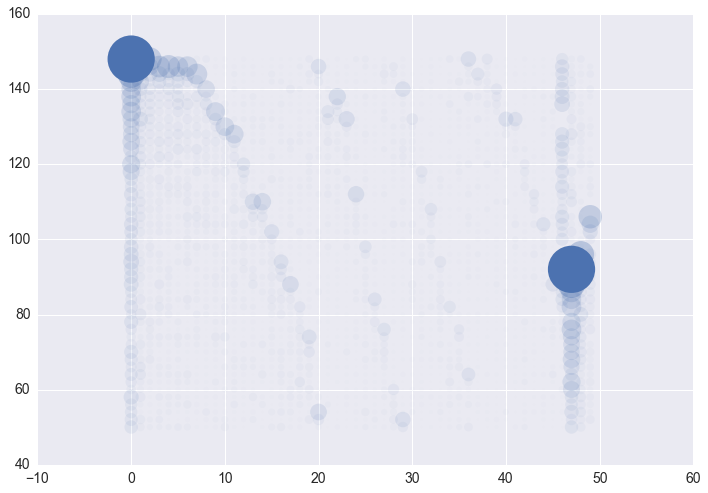

In [140]:
plt.scatter(recasted_scatter_df.bin_nbr_x, recasted_scatter_df.bin_nbr_y, c=colour_matrix, lw=0, s=10*scatter_df.freq)
plt.tight_layout()